# Synthetic Data Generation: Libraries Comparison (SDV and Synthicity)

## Introduction
In this notebook, we will compare two of the most prominent open-source Python packages for synthetic data generation: SDV and Synthcity. The focus is on generating single-table synthetic data, meaning the output will be a single structured dataset.

### Datset Description
The dataset used in this experiment comes from publicly available data on GitHub. It was collected by continuously monitoring a low-energy house in Belgium for 137 days, capturing both electrical energy consumption and environmental data. Energy consumption data was recorded every 10 minutes for various household appliances, while environmental data, such as temperature and humidity, was collected from multiple rooms through a wireless sensor network. Additionally, meteorological data from a nearby airport was merged into the dataset based on timestamps. The full dataset contains 19,735 records and 27 features, but I will only use a subset of it for two main reasons. First, the dataset is too large to be processed efficiently with limited computational resources. Second, I want to evaluate how well the synthetic data generators can generate more data than what they are initially provided with, testing their ability to expand and generalize in different scenarios.

### Analysis Overview
The analysis is structured in two main parts. First, I will explore the SDV and Synthcity packages by using their built-in functions to generate and analyze synthetic data. Then, I will move to the evaluation phase, which is further divided into two parts. The first part will focus on statistical similarities between real and synthetic data, using both the evaluation functions provided by the packages and a custom statistical function that compares key statistical properties such as mean, median, standard deviation, variance, as well as Kolmogorov-Smirnov distance and Wasserstein distance. The second part will evaluate the difference in machine learning model performance when trained on real vs. synthetic data.

It is important to note that in this second part, I am not trying to optimize the models in any way. The goal is not to find the best-performing dataset for machine learning but rather to measure how closely the synthetic data preserves the predictive properties of the real data. A good synthetic data generator should produce datasets that lead to similar machine learning performance as the real data, not necessarily better.

### Goals
The primary goal of this study is to evaluate which synthetic data generator performs best in creating data that is statistically similar to the real dataset.
The study also aims to explore how synthetic and real data differ when used to train machine learning models. By applying multiple machine learning models to both real and synthetic datasets, I will compare their predictive performance using key evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score. 
However, the goal is not to optimize these models but to assess how well the synthetic data preserves the predictive characteristics of the real dataset

Let's start!

First of all, let's import all the needed libraries.

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch 
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
from synthcity.plugins import Plugins

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


Next, we import the dataset containing household energy consumption data.

In [5]:
# Importing the training dataset that we will use to create syntethic data
df = pd.read_csv("Datasets/energydata_complete.csv", nrows=1000) # Taking only the first 1000 rows for memory limitation

# Inspect data 
print(df.head())

              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    9

Inspecting the dataset and handling missing values to ensure data quality before proceeding with analysis.

In [6]:
# Missing values
miss_info = df.isnull().sum()

treshold = 0.5 * len(df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
df = df.dropna(axis=1, thresh=treshold)
print(df.head())
print(df.isnull().sum().sum())

There are 0 columns with more than 500 missing values
              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed

Let's visualize the distribution of energy consumption present in the dataset (Recorded every 10 minutes)

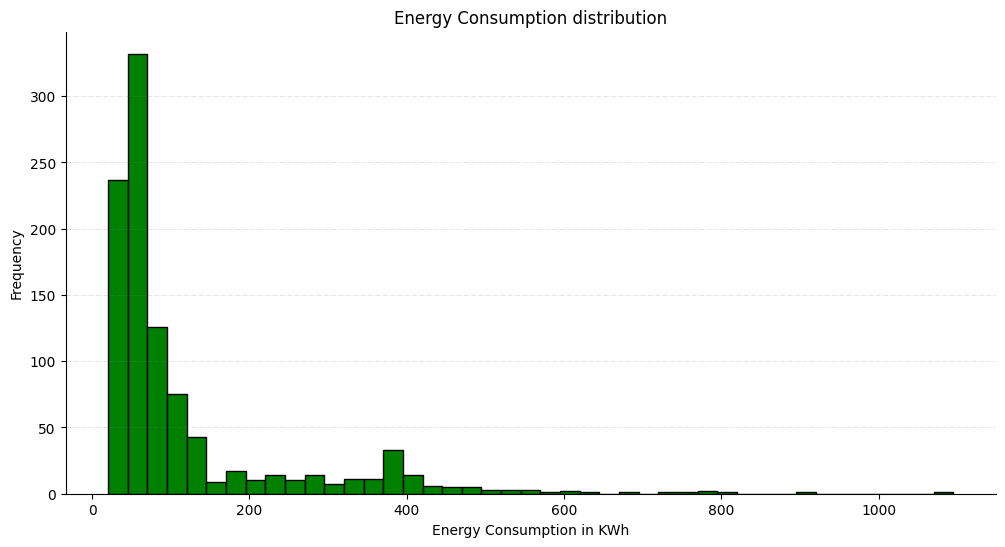

In [13]:
# define bins
min_a = min(df["Appliances"])
max_a = max(df["Appliances"])
binwidth = 25
bins = list(range(min_a, max_a + binwidth, binwidth))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.hist(df["Appliances"], bins=bins,color="green", edgecolor="black")
ax.set_xlabel("Energy Consumption in KWh")
ax.set_ylabel("Frequency")
ax.set_title("Energy Consumption distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False) 
plt.show()

## SDV
Now, let's begin our analysis with the first package: SDV. To correctly use SDV, we first need to define the metadata for our dataset. This metadata will provide the necessary structural information and will be essential for generating synthetic data.

In [14]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name="Energy_consumption")

print(metadata)

{
    "tables": {
        "Energy_consumption": {
            "columns": {
                "date": {
                    "sdtype": "datetime",
                    "datetime_format": "%m/%d/%Y %H:%M"
                },
                "Appliances": {
                    "sdtype": "numerical"
                },
                "lights": {
                    "sdtype": "categorical"
                },
                "T1": {
                    "sdtype": "numerical"
                },
                "RH_1": {
                    "sdtype": "numerical"
                },
                "T2": {
                    "sdtype": "numerical"
                },
                "RH_2": {
                    "sdtype": "numerical"
                },
                "T3": {
                    "sdtype": "numerical"
                },
                "RH_3": {
                    "sdtype": "numerical"
                },
                "T4": {
                    "sdtype": "numerical"
                

After defining the metadata, we can now create the synthesizer. Below is a description of a synthesizer as provided in the SDV documentation:

"The SDV creates synthetic data using machine learning. A synthesizer is an object that facilitates this process.

1. First, a synthesizer is created based on the dataset's metadata.
2. Next, it is trained using real data, where it learns patterns and relationships from the original dataset.
3. Once trained, the synthesizer can generate new synthetic data that mimics the real dataset."

SDV offers different types of synthesizers, each using a distinct machine learning technique. In this study, we will evaluate three synthesizers (for SDV):

- GaussianCopulaSynthesizer: Uses classic statistical methods to model and generate synthetic data.
- CTGANSynthesizer: Uses Generative Adversarial Networks (GANs) to capture complex data distributions and generate synthetic data.
- TVAESynthesizer: Uses Variational Autoencoders (VAEs), a type of deep learning model, to learn and replicate data distributions.

Each of these synthesizers follows a different approach to generating synthetic data, allowing us to compare the effectiveness of traditional statistical methods versus deep learning techniques.

Let's begin with the GaussianCopulaSynthesizer, which uses statistical methods to generate synthetic data.

In [15]:
# Create the synthesizer
synthesizer_gaussian_SDV = GaussianCopulaSynthesizer(metadata)

# Training
synthesizer_gaussian_SDV.fit(df)

# Syntetic data generation
synthetic_data_gaussian_SDV = synthesizer_gaussian_SDV.sample(num_rows=10000)
print(synthetic_data_gaussian_SDV)

# Save the data
synthetic_data_gaussian_SDV.to_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv", index=False)

                  date  Appliances  lights         T1       RH_1         T2  \
0     01/16/2016 23:39          76      20  20.120735  39.596775  19.228507   
1     01/18/2016 05:59         157      10  20.886849  40.614356  19.643012   
2     01/14/2016 23:43          47      20  18.705916  43.724254  17.939402   
3     01/17/2016 11:51          45       0  22.672339  40.408866  21.780287   
4     01/14/2016 01:26         202       0  18.484294  41.252604  17.783064   
...                ...         ...     ...        ...        ...        ...   
9995  01/15/2016 12:43          78       0  19.812468  42.001640  18.486612   
9996  01/11/2016 23:07          31       0  19.321324  46.595300  18.365835   
9997  01/15/2016 04:46          32       0  20.944874  42.040742  20.090704   
9998  01/17/2016 14:59          24      20  20.047907  40.454403  18.846568   
9999  01/14/2016 00:10          51      20  22.003913  40.613978  21.839480   

           RH_2         T3   RH_3         T4  ...  

Next, let's try the CTGANSynthesizer. Since this model benefits from GPU acceleration, this step will be executed in a separate Google Colab notebook to take advantage of the free GPU resources available. The code for this process is still provided below, and the synthetic data generated by the CTGANSynthesizer will be imported later in this notebook for further analysis.

In [16]:
# Create the synthesizer
synthesizer_CTGAN = CTGANSynthesizer(metadata)
# Training
synthesizer_CTGAN.fit(df)

# Syntetic data generation
synthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=10000)
print(synthetic_data_CTGAN)

# Save the data
synthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv", index=False)

                  date  Appliances  lights         T1       RH_1         T2  \
0     01/15/2016 22:12         240      20  21.709802  42.123521  20.828502   
1     01/18/2016 15:30          20      40  18.529615  43.122147  17.700000   
2     01/15/2016 02:03         118      10  20.488332  40.407061  20.070289   
3     01/17/2016 04:38          20      30  21.076374  38.577020  18.759496   
4     01/18/2016 08:38          20      20  21.263788  55.893333  17.977256   
...                ...         ...     ...        ...        ...        ...   
9995  01/17/2016 00:48          20      30  20.879819  43.561350  20.686540   
9996  01/16/2016 13:48         147      10  20.682956  41.161529  17.700000   
9997  01/18/2016 15:30         253      30  21.075383  47.497857  21.891658   
9998  01/18/2016 08:05          60       0  20.219460  42.810432  18.017177   
9999  01/18/2016 02:59          46      20  22.147533  47.871580  21.654767   

           RH_2         T3       RH_3         T4  .

The same process is applied to the TVAESynthesizer, with training performed in a separate Google Colab notebook for GPU acceleration. The generated synthetic data will be imported later for evaluation.

In [17]:
# Create the synthesizer
synthesizer_TVAE_SDV = TVAESynthesizer(metadata)

# Training
synthesizer_TVAE_SDV.fit(df)

# Syntetic data generation
synthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=10000)

# Save the data
synthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv", index=False)

Before manually comparing the statistical similarity between the synthetic and real data, I will first utilize some of the built-in diagnostic and data validation functions provided by the SDV package. To begin, I will use the run_diagnostic function, which performs a basic validity check on each column and ensures that the overall structure of the dataset is preserved. According to the package documentation, this function should return a score of 100% if the dataset is correctly structured.

In [18]:
# Import the data created by the Three models (To not retrain the model everytime, and make the notebook run smothly)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")

print("Diagnostic Report for GaussianCopulaSynthesizer")
diagnostic_report_gaussian_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Diagnostic Report for CTGANSynthesizer")
diagnostic_report_CTGAN_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Diagnostic Report for TVAESynthesizer")
diagnostic_report_TVAE_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

Diagnostic Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 998.61it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 33.75it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1420.01it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 232.95it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1927.16it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 308.75it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



SDV also provides a function to generate a data quality report, which evaluates the statistical similarity between the real and synthetic data.

In [19]:
# Create the quality report for the three models
# Commented out to smoothing the notebook running
print("Quality Report for GaussianCopulaSynthesizer")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

# Save these results
quality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")
quality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")
quality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")

Quality Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 86.08it/s]|
Column Shapes Score: 89.18%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 268.28it/s]|
Column Pair Trends Score: 96.51%

Overall Score (Average): 92.85%

Quality Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 55.18it/s]|
Column Shapes Score: 78.71%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 265.05it/s]|
Column Pair Trends Score: 84.07%

Overall Score (Average): 81.39%

Quality Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 92.89it/s]| 
Column Shapes Score: 88.66%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 277.84it/s]|
Column Pair Trends Score: 94.94%

Overall Score (Average): 91.8%



Another feature offered by SDV is the ability to visualize the data in 2D. This helps in identifying the patterns learned by the synthetic data and spotting differences between the real and synthetic distributions.

In [20]:
# Plot for the GaussianCopulaSynthesizer
fig_gaussian_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_gaussian_SDV.show()

In [21]:
# Plot for the CTGAN model
fig_CTGAN_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_CTGAN_SDV.show()

In [22]:
# Plot for the TVAESynthesizer model
fig_TVAE_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_TVAE_SDV.show()

## Synthcity 
Now, let's begin analyzing Synthcity. Unlike SDV, it does not offer as many built-in functionalities, so I will focus on using the models it provides. In particular, I will evaluate the following synthesizers:

- Bayesian Network Synthesizer – Similar to Gaussian Copula, it relies on statistical methods rather than deep learning.
- CTGAN – The same GAN-based model as the one used in SDV.
- TVAE – The same VAE-based model as the one used in SDV.

Just like with the SDV models, I will train these Synthcity models in a separate notebook. However, the code is still provided below.

In [25]:
# Check available models
print(Plugins().list())

# Create Bayesian Network Model (Comparison with SDV GaussianCopula)
synthesizer_bayes_net_SYN = Plugins().get("bayesian_network")
print("Model initialized Successfully")

# Train on real data (TRAIN ON GPU)
synthesizer_bayes_net_SYN.fit(df)

# Generate synthetic data
synthetic_data_bayes_net_SYN = synthesizer_bayes_net_SYN.generate(10000).dataframe()

# Save the data
synthetic_data_bayes_net_SYN.to_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv", index=False)

# Model to compare
# GaussianCopula VS bayesian_network (Both probabilistic models)
# CTGAN VS ctgan (Exact match)
# TVAE VS tvae (Exact Match)

[2025-03-02T01:46:35.022986+0100][19076][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-03-02T01:46:35.068704+0100][19076][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


['bayesian_network', 'survival_ctgan', 'aim', 'dummy_sampler', 'privbayes', 'ctgan', 'great', 'uniform_sampler', 'timegan', 'arf', 'image_cgan', 'rtvae', 'decaf', 'marginal_distributions', 'nflow', 'ddpm', 'survival_gan', 'pategan', 'dpgan', 'radialgan', 'tvae', 'image_adsgan', 'fflows', 'adsgan', 'survival_nflow', 'survae', 'timevae']
Model initialized Successfully


03/02/2025 01:46:41:WARNING:Probability values don't exactly sum to 1. Differ by: -4.440892098500626e-16. Adjusting values.


In [26]:
# Create Conditional GAN (Comparison with SDV CTGAN)
synthesizer_ctgan_SYN = Plugins().get("ctgan")

# Train the model
synthesizer_ctgan_SYN.fit(df)

# Create and save the data
synthetic_data_ctgan_SYN = synthesizer_ctgan_SYN.generate(10000).dataframe()
synthetic_data_ctgan_SYN.to_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv", index=False)

[2025-03-02T01:47:49.107259+0100][19076][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
  2%|▏         | 30/2000 [00:18<20:07,  1.63it/s]


KeyboardInterrupt: 

In [ ]:
# Create Triplet-Based Variational Autoencoder (Comparison with SDV TVAE)
synthesizer_tvae_SYN = Plugins().get("tvae")

# Train the model
synthesizer_tvae_SYN.fit(df)

# Create synthetic and save them
synthetic_data_tvae_SYN = synthesizer_tvae_SYN.generate(10000).dataframe()
synthetic_data_tvae_SYN.to_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv", index=False)

## Statistical Analysis of Real vs. Synthetic Datasets

First, for a quick comparison, let's use the built-in functions provided by SDV.

In [27]:
# Import all the necessary datasets
real_df = pd.read_csv("Datasets/energydata_complete.csv", nrows=10000)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")
synthetic_data_bayes_net_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv")
synthetic_data_ctgan_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv")
synthetic_data_tvae_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv")

# Evaluate quality with SDV built in package
print("Quality Report for GaussianCopulaSynthesizer SDV")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer SDV")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer SDV")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)


Quality Report for GaussianCopulaSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 101.12it/s]|
Column Shapes Score: 74.61%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 218.68it/s]|
Column Pair Trends Score: 87.9%

Overall Score (Average): 81.26%

Quality Report for CTGANSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 264.15it/s]|
Column Shapes Score: 71.42%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 245.77it/s]|
Column Pair Trends Score: 84.45%

Overall Score (Average): 77.94%

Quality Report for TVAESynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 243.09it/s]|
Column Shapes Score: 70.95%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 239.66it/s]|
Column Pair Trends Score: 86.35%

Overall Score (Average): 78.65%



In [28]:
print("Quality Report for Bayesian Network SYN")
quality_report_bayes_net_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_bayes_net_SYN,
    metadata=metadata
)

print("Quality Report for ctgan SYN")
quality_report_ctgan_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_ctgan_SYN,
    metadata=metadata
)

print("Quality Report for tvae SYN")
quality_report_tvae_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_tvae_SYN,
    metadata=metadata
)

Quality Report for Bayesian Network SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 253.99it/s]|
Column Shapes Score: 77.79%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 263.05it/s]|
Column Pair Trends Score: 88.46%

Overall Score (Average): 83.13%

Quality Report for ctgan SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 248.12it/s]|
Column Shapes Score: 71.32%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 252.48it/s]|
Column Pair Trends Score: 86.36%

Overall Score (Average): 78.84%

Quality Report for tvae SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 203.93it/s]|
Column Shapes Score: 69.42%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 249.07it/s]|
Column Pair Trends Score: 86.65%

Overall Score (Average): 78.04%



To systematically compare the statistical similarity between real and synthetic datasets, I implemented a custom function called overall_similarity. This function evaluates how closely the synthetic data resembles the real data by computing normalized differences in key statistical properties.

The function considers classic statistical measures (mean, median, mode, standard deviation, variance) along with distributional similarity metrics, Kolmogorov-Smirnov (KS) test and Wasserstein distance. These two distribution-based metrics were specifically chosen because they are used internally by SDV’s built-in evaluation functions, as seen in the SDV source code.

The similarity score is computed by applying weighted penalties for statistical deviations, meaning that lower discrepancies between real and synthetic data lead to a higher score. The final output is a percentage-based score (0 to 100), where 100 indicates perfect similarity.

In [30]:
# Create the function
def overall_similarity(real_df, synthetic_df, 
                       weight_mean=0.3, weight_median=0.2, weight_mode=0.1, weight_sd=0.1, weight_var=0.1,
                       weight_ks=0.2, weight_wasserstein=0.1):
    """
    Computes an overall similarity score between real and synthetic datasets based
    on normalized differences in mean, median (if numerical) and mode (if categorical) across columns.

    Parameters:
    - real_df (pd.DataFrame): Real dataset
    - synthetic_df (pd.DataFrame): Synthetic dataset
    - weight_mean (float, optional): Weight for mean difference. Defaults to 0.3.
    - weight_median (float, optional): Weight for median difference. Defaults to 0.3.
    - weight_mode (float, optional): Weight for mode difference. Defaults to 0.2.
    - weight_sd (float, optional): Weight for standard deviation difference. Defaults to 0.1
    - weight_var (float, optional): Weight for variance difference. Defaults to 0.1

    Returns:
    Returns a score between 0 and 100, where 100 indicates perfect similarity.
    """

    # Drop datetime columns
    real_df = real_df.select_dtypes(exclude=["datetime64"])
    synthetic_df = synthetic_df.select_dtypes(exclude=["datetime64"])

    scores = []
    common_cols = set(real_df.columns).intersection(set(synthetic_df.columns))

    for col in common_cols:
        # Check if numerical
        if pd.api.types.is_numeric_dtype(real_df[col]):
            # Classic statistics
            real_mean, syn_mean = real_df[col].mean(), synthetic_df[col].mean() 
            real_median, syn_median = real_df[col].median(), synthetic_df[col].median()
            real_sd, syn_sd = real_df[col].std(), synthetic_df[col].std()
            real_var, syn_var = real_df[col].var(), synthetic_df[col].var()
            
            # Avoid division by zero
            norm_mean = min(1, abs(real_mean - syn_mean) / (abs(real_mean) + 1e-6))
            norm_median = min(1, abs(real_median - syn_median) / (abs(real_median) + 1e-6))
            norm_sd = min(1, abs(real_sd - syn_sd) / (abs(real_sd) + 1e-6))
            norm_var = min(1, abs(real_var - syn_var) / (abs(real_var) + 1e-6))
      
            # Kolomogorov-Smirnov Test (Checks if distributions are similar)
            ks_stat, _ = ks_2samp(real_df[col].dropna(), synthetic_df[col].dropna())
        
            # Wasserstein Distance (Lower means closer distributions)
            wasserstein_dist = wasserstein_distance(real_df[col].dropna(), synthetic_df[col])
            norm_wasserstein = 1 / (1 + wasserstein_dist) # now between 0 and 1

            col_score = 1 - (weight_mean * norm_mean + 
                             weight_median * norm_median + 
                             weight_sd * norm_sd + 
                             weight_var * norm_var +
                             weight_ks * ks_stat + 
                             weight_wasserstein * (1 - norm_wasserstein))
        
        else:
            real_mode = real_df[col].mode()
            syn_mode = synthetic_df[col].mode()
            if not real_mode.empty and not syn_mode.empty:
                mode_score = 1.0 if real_mode.iloc[0] == syn_mode.iloc[0] else 0.0
            else:
                mode_score = 0.0
            col_score = mode_score* weight_mode
        
        scores.append(col_score)
    
    overall_score = np.mean(scores) * 100
    return round(overall_score, 2)


Evaluate the datasets based on this function

In [31]:
sim_score_gaussian_SDV = overall_similarity(real_df, synthetic_data_gaussian_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Gaussian SDV: ", sim_score_gaussian_SDV)

sim_score_CTGAN_SDV = overall_similarity(real_df, synthetic_data_CTGAN_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SDV: ", sim_score_CTGAN_SDV)

sim_score_TVAE_SDV = overall_similarity(real_df, synthetic_data_TVAE_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SDV: ", sim_score_TVAE_SDV)

sim_score_bayes_net_SYN = overall_similarity(real_df, synthetic_data_bayes_net_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Bayes Net SYN: ", sim_score_bayes_net_SYN)

sim_score_ctgan_SYN = overall_similarity(real_df, synthetic_data_ctgan_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SYN: ", sim_score_ctgan_SYN)

sim_score_tvae_SYN =  overall_similarity(real_df, synthetic_data_tvae_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SYN: ", sim_score_tvae_SYN)

Similarity between real data and synthetic data with Gaussian SDV:  79.83
Similarity between real data and synthetic data with CTGAN SDV:  75.5
Similarity between real data and synthetic data with TVAE SDV:  75.91
Similarity between real data and synthetic data with Bayes Net SYN:  80.69
Similarity between real data and synthetic data with CTGAN SYN:  79.19
Similarity between real data and synthetic data with TVAE SYN:  78.59


## Evaluating Predictive Utility

This step aims to compare how well machine learning models trained on real data perform against those trained on synthetic data. The goal is not to optimize model performance but to assess how closely the synthetic data preserves the predictive characteristics of the real dataset. 

To assess how well synthetic data preserves the predictive properties of real data, the function in the following codeblock trains multiple machine learning models on both real and synthetic datasets and stores the results in a structured format.

Rather than directly comparing the performances, the function organizes the evaluation metrics (MAE, MSE, R²) into three key outputs:

- real_metrics_df – The performance of ML models trained on real data.
- detailed_syn_metrics – The performance of ML models trained on each synthetic dataset, stored in a nested dictionary for granular analysis.
- overall_syn_metrics_df – The average performance of each synthetic data generator across all ML models, making it easier to analyze general trends.

This structured output allows for further comparisons and analysis in subsequent steps, where we can examine the differences between real and synthetic data performances.

In [32]:
# Divide all the datasets in training and targets
X_real = real_df.drop(["Appliances", "date"], axis=1)
y_real = real_df["Appliances"]

X_gaussian_SDV = synthetic_data_gaussian_SDV.drop(["Appliances", "date"], axis=1)
y_gaussian_SDV = synthetic_data_gaussian_SDV["Appliances"]

X_bayes_net_SYN = synthetic_data_bayes_net_SYN.drop(["Appliances", "date"], axis=1)
y_bayes_net_SYN = synthetic_data_bayes_net_SYN["Appliances"]

X_CTGAN_SDV = synthetic_data_CTGAN_SDV.drop(["Appliances", "date"], axis=1)
y_CTGAN_SDV = synthetic_data_CTGAN_SDV["Appliances"]

X_ctgan_SYN = synthetic_data_ctgan_SYN.drop(["Appliances", "date"], axis=1)
y_ctgan_SYN = synthetic_data_ctgan_SYN["Appliances"]

X_TVAE_SDV = synthetic_data_TVAE_SDV.drop(["Appliances", "date"], axis=1)
y_TVAE_SDV = synthetic_data_TVAE_SDV["Appliances"]

X_tvae_SYN = synthetic_data_tvae_SYN.drop(["Appliances", "date"], axis=1)
y_tvae_SYN = synthetic_data_tvae_SYN["Appliances"]

synthetic_datasets = {
    "Gaussian SDV": (X_gaussian_SDV, y_gaussian_SDV),
    "Bayes Net SYN": (X_bayes_net_SYN, y_bayes_net_SYN),
    "CTGAN SDV": (X_CTGAN_SDV, y_CTGAN_SDV),
    "CTGAN SYN": (X_ctgan_SYN, y_ctgan_SYN),
    "TVAE SDV": (X_TVAE_SDV, y_TVAE_SDV),
    "TVAE SYN": (X_tvae_SYN, y_tvae_SYN)
}

models = {
    "XGB": XGBRegressor(colsample_bytree = 0.8, 
                     gamma = 0, learning_rate = 0.1, 
                     max_depth = 5, 
                     n_estimators = 100, 
                     subsample = 1.0, 
                     random_state=1618),
    "RF": RandomForestRegressor(max_depth=40, max_features="sqrt", n_estimators=240),
    "SVR": SVR(C=8, gamma=1, kernel="rbf"),
    "Linear": LinearRegression()
}

def evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618):
    """
    Evaluate all models on all synthetic datasets.

    Parameters:
    - X_real (pd.DataFrame): Features from the real dataset
    - y_real (pd.Series): Target variable from the real dataset
    - synthetic_datasets (dict): Dictionary of synthetic datasets
    - models (dict): Dictionary of models to evaluate
    - test_size (float, optional): Proportion of data to use for testing. Defaults to 0.2.
    - random_state (int, optional): Seed for random number generation. Defaults to 1618

    Returns:
    - real_metrics_df (pd.DataFrame): Evaluation metrics for each model on real data
    - overall_syn_metrics_df (pd.DataFrame): Average Evaluation metrics
    - detailed_syn_metrics (dict): Nested dictionary of metrics for each synthetic data generator
    """

    # Scale the real data
    scaler = StandardScaler()
    X_real_scaled = scaler.fit_transform(X_real)

    # Split real
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
        X_real_scaled, y_real, test_size=test_size, random_state=random_state
    )

    # Evaluate each model on real data
    real_metrics = {}
    for model_name, model in models.items():
        model_clone = clone(model)
        model_clone.fit(X_train_real, y_train_real)
        y_pred_real = model_clone.predict(X_test_real)

        mae_real = mean_absolute_error(y_test_real, y_pred_real)
        mse_real = mean_squared_error(y_test_real, y_pred_real)
        r2_real = r2_score(y_test_real, y_pred_real)

        real_metrics[model_name] = {"MAE": mae_real, "MSE": mse_real, "R2": r2_real}

    real_metrics_df = pd.DataFrame(real_metrics).T

    # Eveluate each syntehtic datasets on each model
    # this step will take a while, since I'm running it on
    # my laptop CPU
    detalied_syn_metrics = {method: {} for method in synthetic_datasets.keys()}
    for method, (X_syn, y_syn) in synthetic_datasets.items():
        X_syn_scaled = scaler.transform(X_syn)
        X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
            X_syn_scaled, y_syn, test_size=test_size, random_state=random_state
        )
        for model_name, model in models.items():
            model_clone = clone(model)
            model_clone.fit(X_train_syn, y_train_syn)
            y_pred_syn = model_clone.predict(X_test_syn)

            mae_syn = mean_absolute_error(y_test_syn, y_pred_syn)
            mse_syn = mean_squared_error(y_test_syn, y_pred_syn)
            r2_syn = r2_score(y_test_syn, y_pred_syn)

            detalied_syn_metrics[method][model_name] = {"MAE": mae_syn, "MSE": mse_syn, "R2": r2_syn}

    # Compute avareages (across ML models performamces)
    overall_syn_metrics = {}
    for method, metrics_dict in detalied_syn_metrics.items():
        mae_avg = np.mean([metrics_dict[m]["MAE"] for m in metrics_dict])
        mse_avg = np.mean([metrics_dict[m]["MSE"] for m in metrics_dict])
        r2_avg = np.mean([metrics_dict[m]["R2"] for m in metrics_dict])
        overall_syn_metrics[method] = {"MAE_avg": mae_avg, "MSE_avg": mse_avg, "R2_avg": r2_avg}


    overall_syn_metrics_df = pd.DataFrame(overall_syn_metrics).T

    return real_metrics_df, overall_syn_metrics_df, detalied_syn_metrics
    

Now, let's use the function to generate the structured DataFrames needed for further analysis and comparison.

In [33]:
# Create the metrics datasets
real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics = evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618)

real_metrics_df.to_csv("Metrics_performances/real_metrics.csv", index=False)
overall_syn_metrics_df.to_csv("Metrics_performances/overall_syn_metrics.csv", index=False)
print(real_metrics_df.head())
print(overall_syn_metrics_df.head())
print(detailed_syn_metrics)

              MAE           MSE        R2
XGB     43.551094   7108.658203  0.432893
RF      35.946811   5449.155885  0.565283
SVR     49.852094  12912.792504 -0.030144
Linear  59.203290  10398.288761  0.170456
                 MAE_avg       MSE_avg    R2_avg
Gaussian SDV   56.650065   6985.803822  0.106986
Bayes Net SYN  41.948566   7730.245669  0.547080
CTGAN SDV      78.689615  14398.125878 -0.025611
CTGAN SYN      67.928020  13126.752484  0.103053
TVAE SDV       37.310477   5286.203709  0.103419
{'Gaussian SDV': {'XGB': {'MAE': 55.94533157348633, 'MSE': 6498.0751953125, 'R2': 0.16933327913284302}, 'RF': {'MAE': 58.18095416666667, 'MSE': 6637.769543597613, 'R2': 0.15147570857989978}, 'SVR': {'MAE': 58.21014821572551, 'MSE': 8721.609421630717, 'R2': -0.11490726002534135}, 'Linear': {'MAE': 54.26382643396534, 'MSE': 6085.761126570284, 'R2': 0.2220404589587116}}, 'Bayes Net SYN': {'XGB': {'MAE': 33.77122116088867, 'MSE': 3705.2236328125, 'R2': 0.7829084396362305}, 'RF': {'MAE': 21.21430

Compute the absolute and relative differences between the performances of ML models on real and synthetic data. The smaller the difference, the better the synthetic data replicates the characteristics of the real dataset. It is important to note that we are not trying to identify the model that achieves the best performance but rather the synthetic data generator that produces results most aligned with those obtained from real data.

In [34]:
# Import dataframes
real_metrics_df = pd.read_csv("Metrics_performances/real_metrics.csv")
overall_syn_metrics_df = pd.read_csv("Metrics_performances/overall_syn_metrics.csv")

# Compute the differences
diff_metrics = overall_syn_metrics_df.copy()

# Absolute difference
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics[f"Delta_{metric}"] = abs(real_metrics_df.mean()[metric] - overall_syn_metrics_df[f"{metric}_avg"])

# Percentages, relative difference
for metric in ["MAE", "MSE"]:
    diff_metrics[f"Real_Delta_{metric} (%)"] = (diff_metrics[f"Delta_{metric}"] / (real_metrics_df.mean()[metric])) * 100

# For R2 the difference is simplier since it's already a percentage
diff_metrics["Real_Delta_R2 (%)"] = (diff_metrics["Delta_R2"] / (abs(real_metrics_df.mean()["R2"]))) * 100

model_names = ["Gaussian SDV", "Bayesian Net SYN", "CTGAN SDV", "ctgan SYN", "TVAE SDV", "tvae SYN"]
diff_metrics.index = model_names
print(diff_metrics.index)

print(diff_metrics)


Index(['Gaussian SDV', 'Bayesian Net SYN', 'CTGAN SDV', 'ctgan SYN',
       'TVAE SDV', 'tvae SYN'],
      dtype='object')
                    MAE_avg       MSE_avg    R2_avg  Delta_MAE    Delta_MSE  \
Gaussian SDV      56.650065   6985.803822  0.106986   9.511743  1981.420016   
Bayesian Net SYN  41.948566   7730.245669  0.547080   5.189756  1236.978169   
CTGAN SDV         78.689615  14398.125878 -0.025611  31.551292  5430.902040   
ctgan SYN         67.928020  13126.752484  0.103053  20.789698  4159.528646   
TVAE SDV          37.310477   5286.203709  0.103419   9.827846  3681.020129   
tvae SYN          69.145731  11955.691838  0.153614  22.007409  2988.468000   

                  Delta_R2  Real_Delta_MAE (%)  Real_Delta_MSE (%)  \
Gaussian SDV      0.177636           20.178365           22.096248   
Bayesian Net SYN  0.262458           11.009632           13.794438   
CTGAN SDV         0.310233           66.933423           60.563917   
ctgan SYN         0.181569           44.103

Visualize the results using a bar plot to compare the percentage differences between real and synthetic data across the three evaluation metrics (MAE, MSE, and R²). 

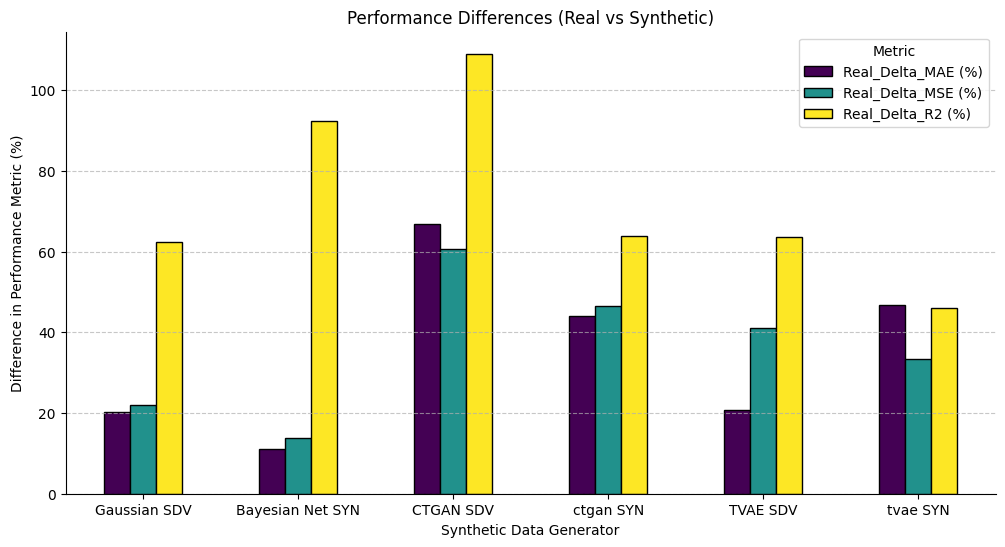

In [35]:
metrics = ["Real_Delta_MAE (%)", "Real_Delta_MSE (%)", "Real_Delta_R2 (%)"]

fig, ax = plt.subplots(figsize=(12,6))
# Plot bar chart
diff_metrics[metrics].plot(kind="bar", ax=ax, colormap="viridis", edgecolor="black")

ax.set_title("Performance Differences (Real vs Synthetic)")
ax.set_ylabel("Difference in Performance Metric (%)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Metric")
plt.show()


To get a clearer picture of which synthetic data generator overall produces data that best aligns with the performance of real data across different ML models, we create a single aggregated metric that combines MAE, MSE, and R².

                   MAE_avg   MSE_avg    R2_avg  Delta_MAE  Delta_MSE  \
Gaussian SDV      0.467375  0.186525  0.231533   0.163950   0.177505   
Bayesian Net SYN  0.112088  0.268225  1.000000   0.000000   0.000000   
CTGAN SDV         1.000000  1.000000  0.000000   1.000000   1.000000   
ctgan SYN         0.739927  0.860471  0.224666   0.591769   0.696853   
TVAE SDV          0.000000  0.000000  0.225304   0.175942   0.582758   
tvae SYN          0.769355  0.731952  0.312953   0.637962   0.417626   

                  Delta_R2  Real_Delta_MAE (%)  Real_Delta_MSE (%)  \
Gaussian SDV      0.260169            0.163950            0.177505   
Bayesian Net SYN  0.733436            0.000000            0.000000   
CTGAN SDV         1.000000            1.000000            1.000000   
ctgan SYN         0.282111            0.591769            0.696853   
TVAE SDV          0.280071            0.175942            0.582758   
tvae SYN          0.000000            0.637962            0.417626   

    

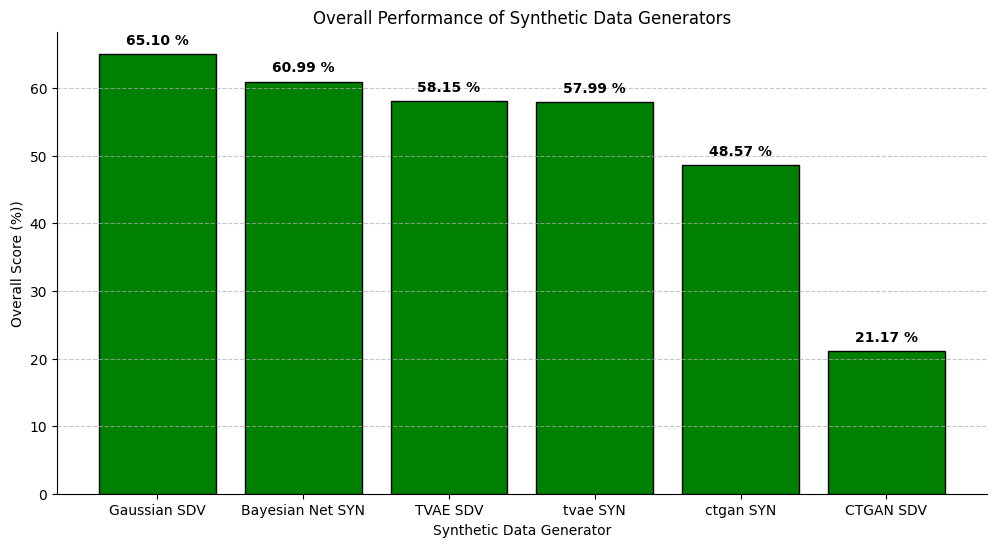

In [36]:
# Normalize ecah metric so that every metric is in between 0 and 1 (min-max scaling)
diff_metrics_norm = (diff_metrics - diff_metrics.min()) / (diff_metrics.max() - diff_metrics.min())
print(diff_metrics_norm)

# The higher the better
diff_metrics["Overall_Score"] =  100 - diff_metrics[["Real_Delta_MAE (%)", "Real_Delta_MSE (%)", "Real_Delta_R2 (%)"]].mean(axis=1) 

# Rank the models
diff_metrics = diff_metrics.sort_values(by="Overall_Score", ascending=False)

# Visualize the rank
fig, ax = plt.subplots(1,1,figsize=(12,6))
bars = ax.bar(diff_metrics.index, diff_metrics["Overall_Score"], color="green", edgecolor="black")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 
            height + 1, 
            f"{height:.2f} %",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_title("Overall Performance of Synthetic Data Generators")
ax.set_ylabel("Overall Score (%))")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Conclusions
### Statistical Similarity
Overall, both packages performed reasonably well. The Bayesian Network model from the Synthcity package achieved the highest overall similarity score (80.69%), though all the other models produced results that were very close to this.

One factor that likely influenced the results is that I imported only 1,000 rows from the real dataset, while generating 10,000 synthetic rows. In a previous test where I used the same number of rows for both real and synthetic datasets, the similarity scores were consistently above 90%. This suggests, as expected, that synthetic data generators perform better when trained on a dataset of comparable size to the synthetic data they are expected to generate.

In general, Synthcity performed slightly better than SDV, but I must highlight that SDV was much easier to use. The excellent documentation made implementation straightforward, and the package provides a wide variety of built-in functions for generating, evaluating, and visualizing synthetic data in an all-in-one environment.

### Machine Learning Performance Comparison
As expected, the predictive utility comparison yielded lower scores. For a synthetic dataset to perfectly replicate ML model performance on real data, it would have to be identical to the real data—something that is not only impossible but also undesirable in synthetic data generation. Even slight variations in data distribution can significantly affect machine learning model performance.

That being said, the ML models trained on synthetic data did not perform drastically worse overall—though some results were more affected than others. The two statistical-based models performed the best, with:

- Gaussian SDV achieving a 65.10% similarity score
- Bayesian Network SYN achieving 60.99%

NOTE: This score represents the inverse of the percentage difference between the aggregated ML model performance on real vs. synthetic data. Initially, a lower percentage difference meant that synthetic data was more similar to real data, but I inverted the score (by subtracting from 100) to make it more intuitive: a higher score now indicates better alignment.

On the other hand, the deep learning-based models performed worse, with the CTGAN SDV scoring only 21.17%, which suggests that this model struggled significantly with this dataset and may require further investigation.

### Final Thoughts
It is important to acknowledge that the structure of this dataset may have influenced the results. The dataset is primarily numerical, which makes it easier for traditional statistical models to replicate its structure, while deep learning-based generators (such as CTGAN and TVAE) tend to perform better on unstructured data like text or images.

In conclusion, both SDV and Synthcity performed reasonably well, and neither package clearly outperformed the other, as they rely on similar underlying models. However, from a usability perspective, I would personally recommend SDV due to its user-friendly documentation and ease of use.